!!! From approximately May 2021 on, only AnzFallVortag can be used to figure out new cases, other options have been shifted.

# RKI Data Manipulation

## Introduction

This notebooks tests the handling of the RKI_History CSV-File (Source: https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/6d78eb3b86ad4466a8e264aa2e32a2e4_0/data?page=17627) with the overall goal of plotting the respective data.

## Preparation
In the first step, we import the RKI Data and do some declarations.

In [175]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
import math

In [176]:
rki=pd.read_csv('External Data/RKI_History.csv', sep=',', header='infer')
#rki['Datum']=pd.to_datetime(rki_raw['Datum'])
#rki=rki.sort_values(by='AdmUnitId')
rki=rki.sort_values(by='Datum')

lk=np.array(rki['AdmUnitId'])
lk_comp_num=len(lk)
day=np.array(rki['Datum'])
case=np.array(rki['AnzFallVortag'])
case_cum=np.array(rki['KumFall'])
rki

,ObjectId,AdmUnitId,BundeslandId,Datum,AnzFallNeu,AnzFallVortag,AnzFallErkrankung,AnzFallMeldung,KumFall
0,1,0,0,2020/03/01 00:00:00+00,0,36,221,11,171
43202,43203,5362,5,2020/03/01 00:00:00+00,0,0,1,0,0
43750,43751,5366,5,2020/03/01 00:00:00+00,0,0,1,0,0
169359,169360,14730,14,2020/03/01 00:00:00+00,0,0,0,0,0
44316,44317,5370,5,2020/03/01 00:00:00+00,0,14,37,9,74
...,...,...,...,...,...,...,...,...,...
75849,75850,7235,7,2021/05/07 00:00:00+00,5,0,0,4,4188
120122,120123,9371,9,2021/05/07 00:00:00+00,8,0,0,7,4662
17731,17732,3157,3,2021/05/07 00:00:00+00,29,0,0,27,5179
140592,140593,9764,9,2021/05/07 00:00:00+00,31,0,0,8,1973


Now we import a database that contains population sizes of all Administrative Units. (Source: https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0)

In [177]:
pop=pd.read_csv('External Data/RKI_Corona_Landkreise.csv', sep=',', header='infer')
lk_popcalc=np.array(pop['AdmUnitId'])
lk_popsize=np.array(pop['EWZ'])
lk_num=len(lk_popsize)


## Setup for intern calculations
For intern overview and calculations, we set up an array consisting of the RKI Administrative Unit IDs of the LKs in the chosen region as well as a dictionary for later labeling.

In [178]:
lk_hildesheim_id=3254
lk_holzminden_id=3255
lk_goslar_id=3153
lk_höxter_id=5762
lk_northeim_id=3155
lk_göttingen_id=3159
lk_harz_id=15085
lk_kassel_id=6633
sk_kassel_id=6611
lk_werrameißnerkreis_id=6636
lk_eichsfeld_id=16061
lk_nordhausen_id=16062

region_ids=[lk_hildesheim_id,lk_holzminden_id,lk_goslar_id,lk_höxter_id,lk_northeim_id,lk_göttingen_id,lk_harz_id,lk_kassel_id,sk_kassel_id,lk_werrameißnerkreis_id,lk_eichsfeld_id,lk_nordhausen_id]
region_num=len(region_ids)
region_names=['Hildesheim','Holzminden','Goslar', 'Höxter','Northeim','Göttingen','Harz','Kassel (LK)','Kassel (SK)', 'Werra-Meißner-Kreis','Eichsfeld','Nordhausen']
labels={}
for intern_region_number in range(region_num):
    labels[intern_region_number]=region_names[intern_region_number]
    
labels

{0: 'Hildesheim',
 1: 'Holzminden',
 2: 'Goslar',
 3: 'Höxter',
 4: 'Northeim',
 5: 'Göttingen',
 6: 'Harz',
 7: 'Kassel (LK)',
 8: 'Kassel (SK)',
 9: 'Werra-Meißner-Kreis',
 10: 'Eichsfeld',
 11: 'Nordhausen'}

We now find out the number of documented time steps:

In [179]:
time=0
for i in lk:
    if i==0:
        time+=1
        
time

433

This is a function that evaluates the 7-day-incidence (per 100,000 inhabitants) in a single cell using a given array of infections over time and the population size:

In [180]:
def n_day_moving_average(case_array,n):
    output=np.zeros((len(case_array)))
    for i in range(len(case_array)):
        if(i>=n-1):
            isum=0
            for j in range(n):
                isum+=case_array[i-j]
            output[i]=isum
        else:
            output[i]=0 #or undefined, not sure tbh
    return output/n

def n_day_incidence(case_array,pop,n):
    return n*n_day_moving_average(case_array,n)/pop*100000

The following cell contains the main work, namely transferring the data from several (mixed-up) position in multiple source into one array that is easy to cope with and only includes the information on the regarded region.

In [194]:
dimensions=3 #here: new cases, cumulative cases, 7-day-incidence
region_cases=np.zeros((region_num,dimensions, time))
region_popsize=np.zeros((region_num))

for intern_region_number in range(region_num):
    current_time=0
    for i in range(lk_comp_num):
        if lk[i]==region_ids[intern_region_number]:
            region_cases[intern_region_number][0][current_time]=case[i]
            region_cases[intern_region_number][1][current_time]=case_cum[i]
            current_time+=1
    for j in range(lk_num):
        if lk_popcalc[j]==region_ids[intern_region_number]:
            region_popsize[intern_region_number]=lk_popsize[j]
    region_cases[intern_region_number][2]=n_day_incidence(region_cases[intern_region_number][0],region_popsize[intern_region_number],7)
    
region_popsize=np.round(region_popsize,0).astype('int')

region_popsize

array([275817,  70458, 136292, 140251, 132285, 326041, 213310, 236764,
       202137, 100629, 100006,  83416])

Now, we can easily plot e.g. 

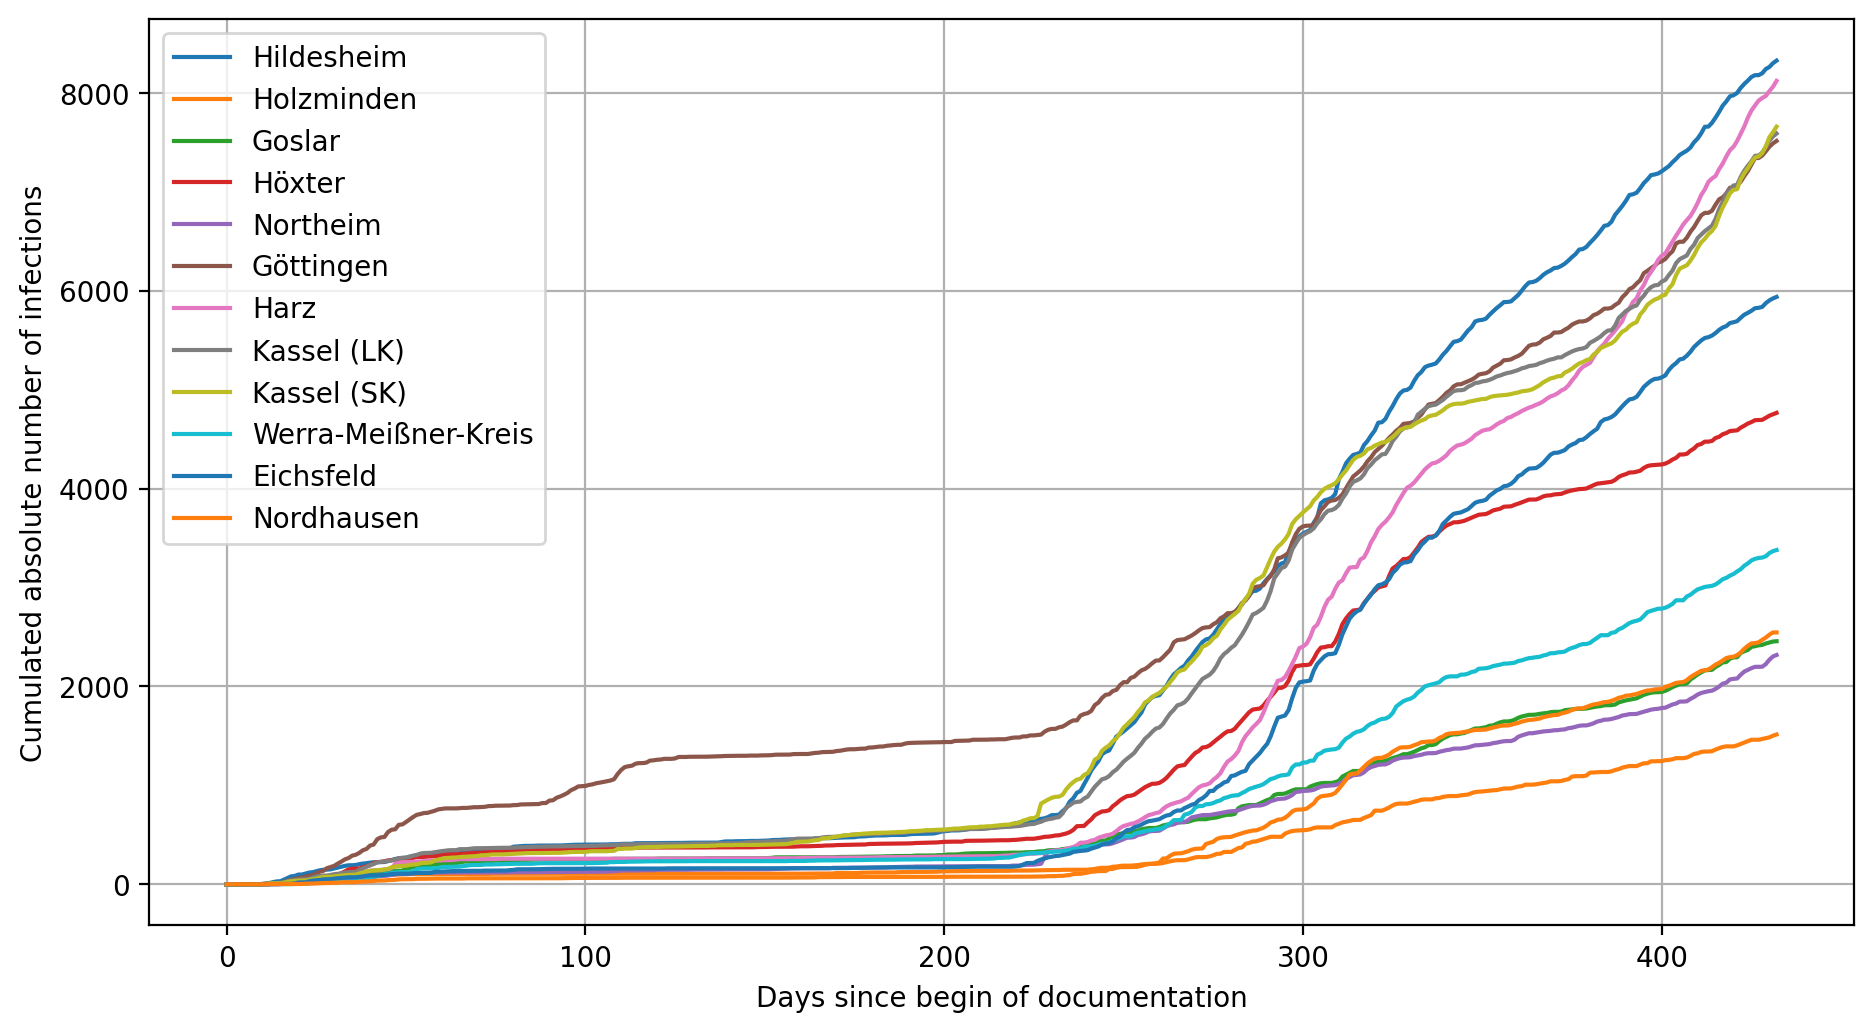

In [182]:
show_num=12

plt.figure(figsize=(11,6), dpi=200)
plt.xlabel('Days since begin of documentation')
plt.ylabel('Cumulated absolute number of infections')
plt.grid()
for p in range(show_num):
    plt.plot(range(time),region_cases[p][1],label=labels[p])
plt.legend()
plt.show()

We can also plot examples of the 7-day-incidence.

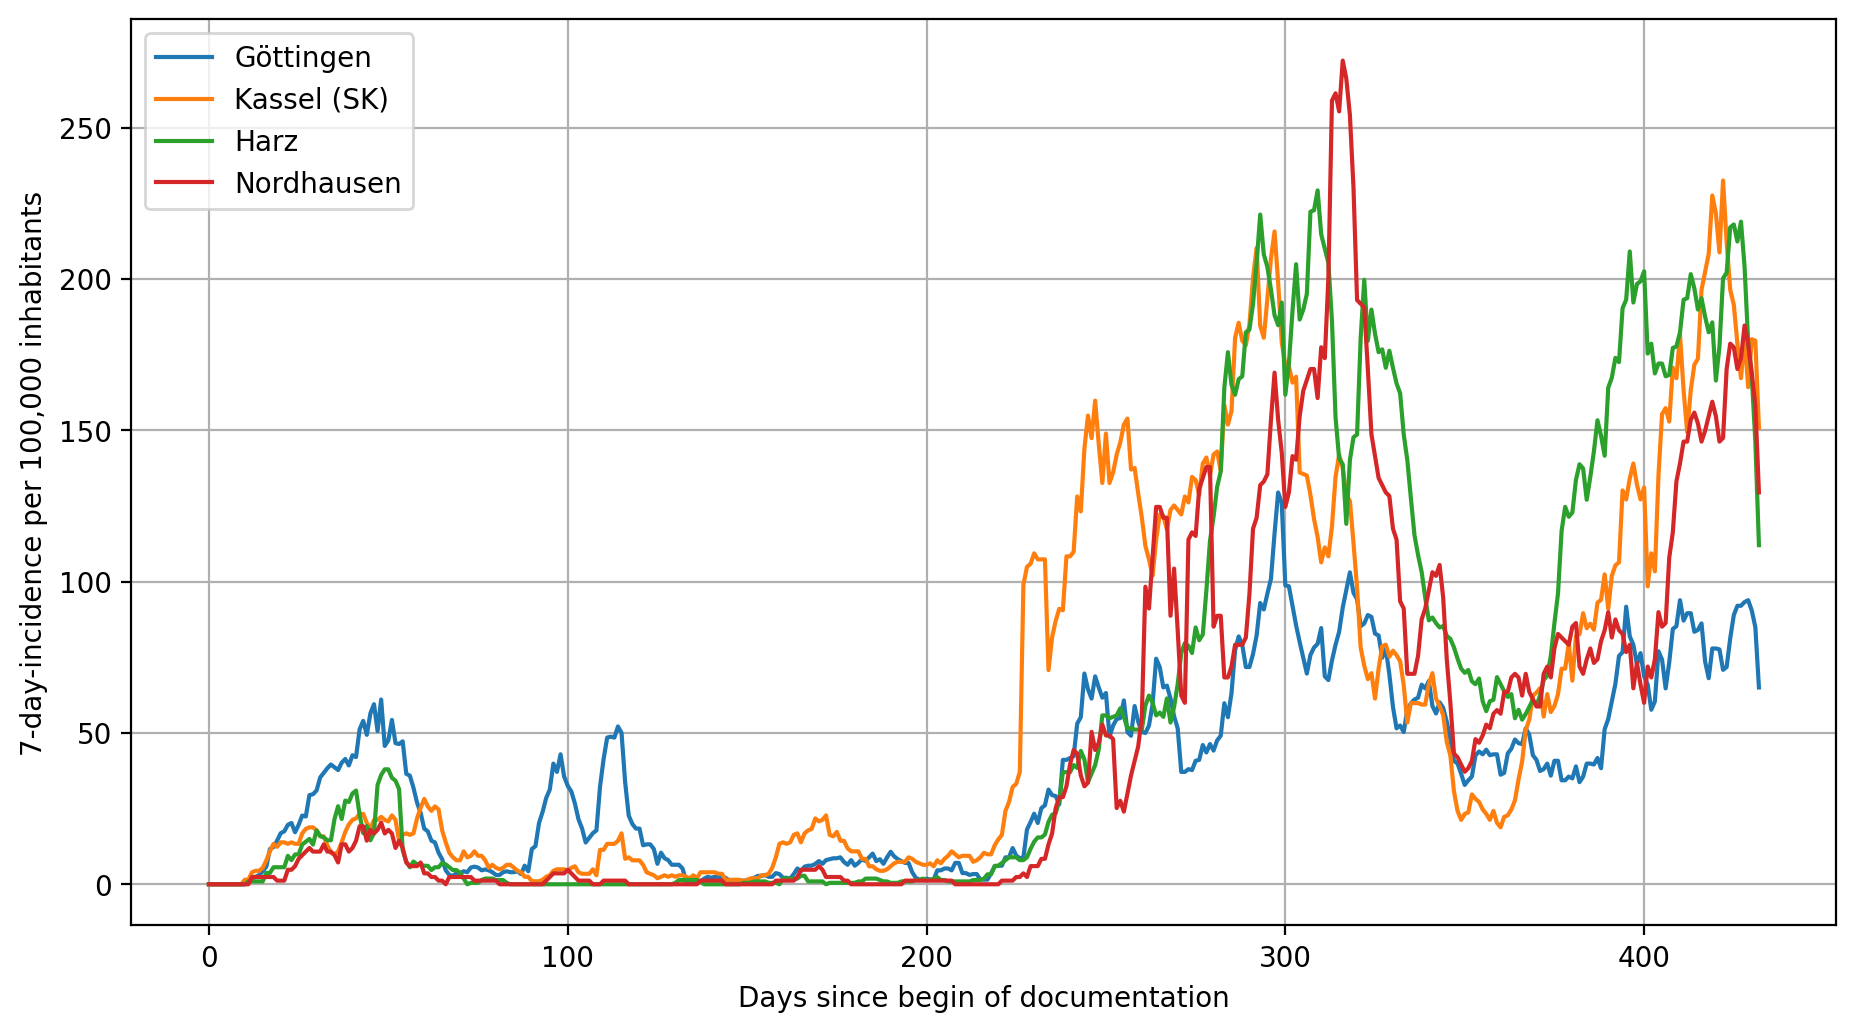

In [201]:
plt.figure(figsize=(11,6), dpi=200)
plt.xlabel('Days since begin of documentation')
plt.ylabel('7-day-incidence per 100,000 inhabitants')
plt.grid()
for p in [5,8,6,11]:
    plt.plot(range(time),region_cases[p][2],label=labels[p])
    #plt.plot(range(time),n_day_moving_average(region_cases[p][0],7)/region_popsize[p]*7*100000,label=labels[p])
plt.legend(loc='upper left')
plt.show()

Using the code from previous notebooks (update 28/04: weighted!), the graph of the regarded region can easily be constructed.

In [184]:
g11_adjacence=np.array([   [0, 1705+805, 802+1316, 0, 1046+863, 0, 0, 0, 0, 0, 0, 0],
                           [1705+805, 0, 0, 3646+2623, 994+1305, 0, 0, 0, 0, 0, 0, 0],
                           [802+1316, 0, 0, 0, 857+809, 1659+1955, 3677+1042, 0, 0, 0, 0, 99+0],
                           [0, 3646+2623, 0, 0, 0, 0, 0, 1313+1116, 0, 0, 0, 0],
                           [1046+863, 994+1305, 857+809, 0, 0, 11166+5710, 0, 611+518, 0, 0, 0, 0],
                           [0, 0, 1659+1955, 0, 11166+5710, 0, 0, 2637+1920, 1633+3551, 2146+710, 7160+1288, 1658+809],
                           [0, 0, 3677+1042, 0, 0, 0, 0, 0, 0, 0, 0, 194+182],
                           [0, 0, 0, 1313+1116, 611+518, 2637+1920, 0, 0, 35268+13753, 912+1950, 0, 0],
                           [0, 0, 0, 0, 0, 1633+3551, 0, 35268+13753, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0, 2146+710, 0, 912+1950, 0, 0, 1486+548, 0],
                           [0, 0, 0, 0, 0, 7160+1288, 0, 0, 0, 1486+548, 0, 984+1755],
                           [0, 0, 99+0, 0, 0, 1658+809, 194+182, 0, 0, 0, 984+1755, 0]])

def makegraph(matrix):
    G = nx.DiGraph()
    dim=len(matrix[0])
    for i in range(dim): 
        for j in range(dim): 
            if matrix[i][j] != 0: 
                G.add_edge(i,j, weight=matrix[i][j])
    return G

G1=makegraph(g11_adjacence)
weights = [np.sqrt(G1[u][v]['weight']/200) for u,v in G1.edges]

pos = {0:(0,10),1:(0,7),2:(7,10),3:(0,2),4:(3,7),5:(7,5),6:(11,11),7:(3,2),8:(5.5,2.5),9:(7,0),10:(11,2),11:(11,7)}

In the next step, we set up the colorbar and the plot function that starts plotting the state 100 days ago.

In [185]:
ccm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin = 0, vmax=0.08))
ccm._A = []  
    
def plot_cstate(animation_time):
    cmap=[]
    for node in G1:
        cmap.append(region_cases[node][1][time-100+animation_time])
    q=nx.draw_networkx(G1,pos,node_size=region_popsize/60, labels=labels, with_labels=True, font_color='black', width=weights, node_color=cmap/region_popsize ,edge_color='grey',cmap=plt.cm.YlOrRd,vmin=0, vmax=0.07,arrowsize=1e-10)
    return q

First, we can plot one state as an example.

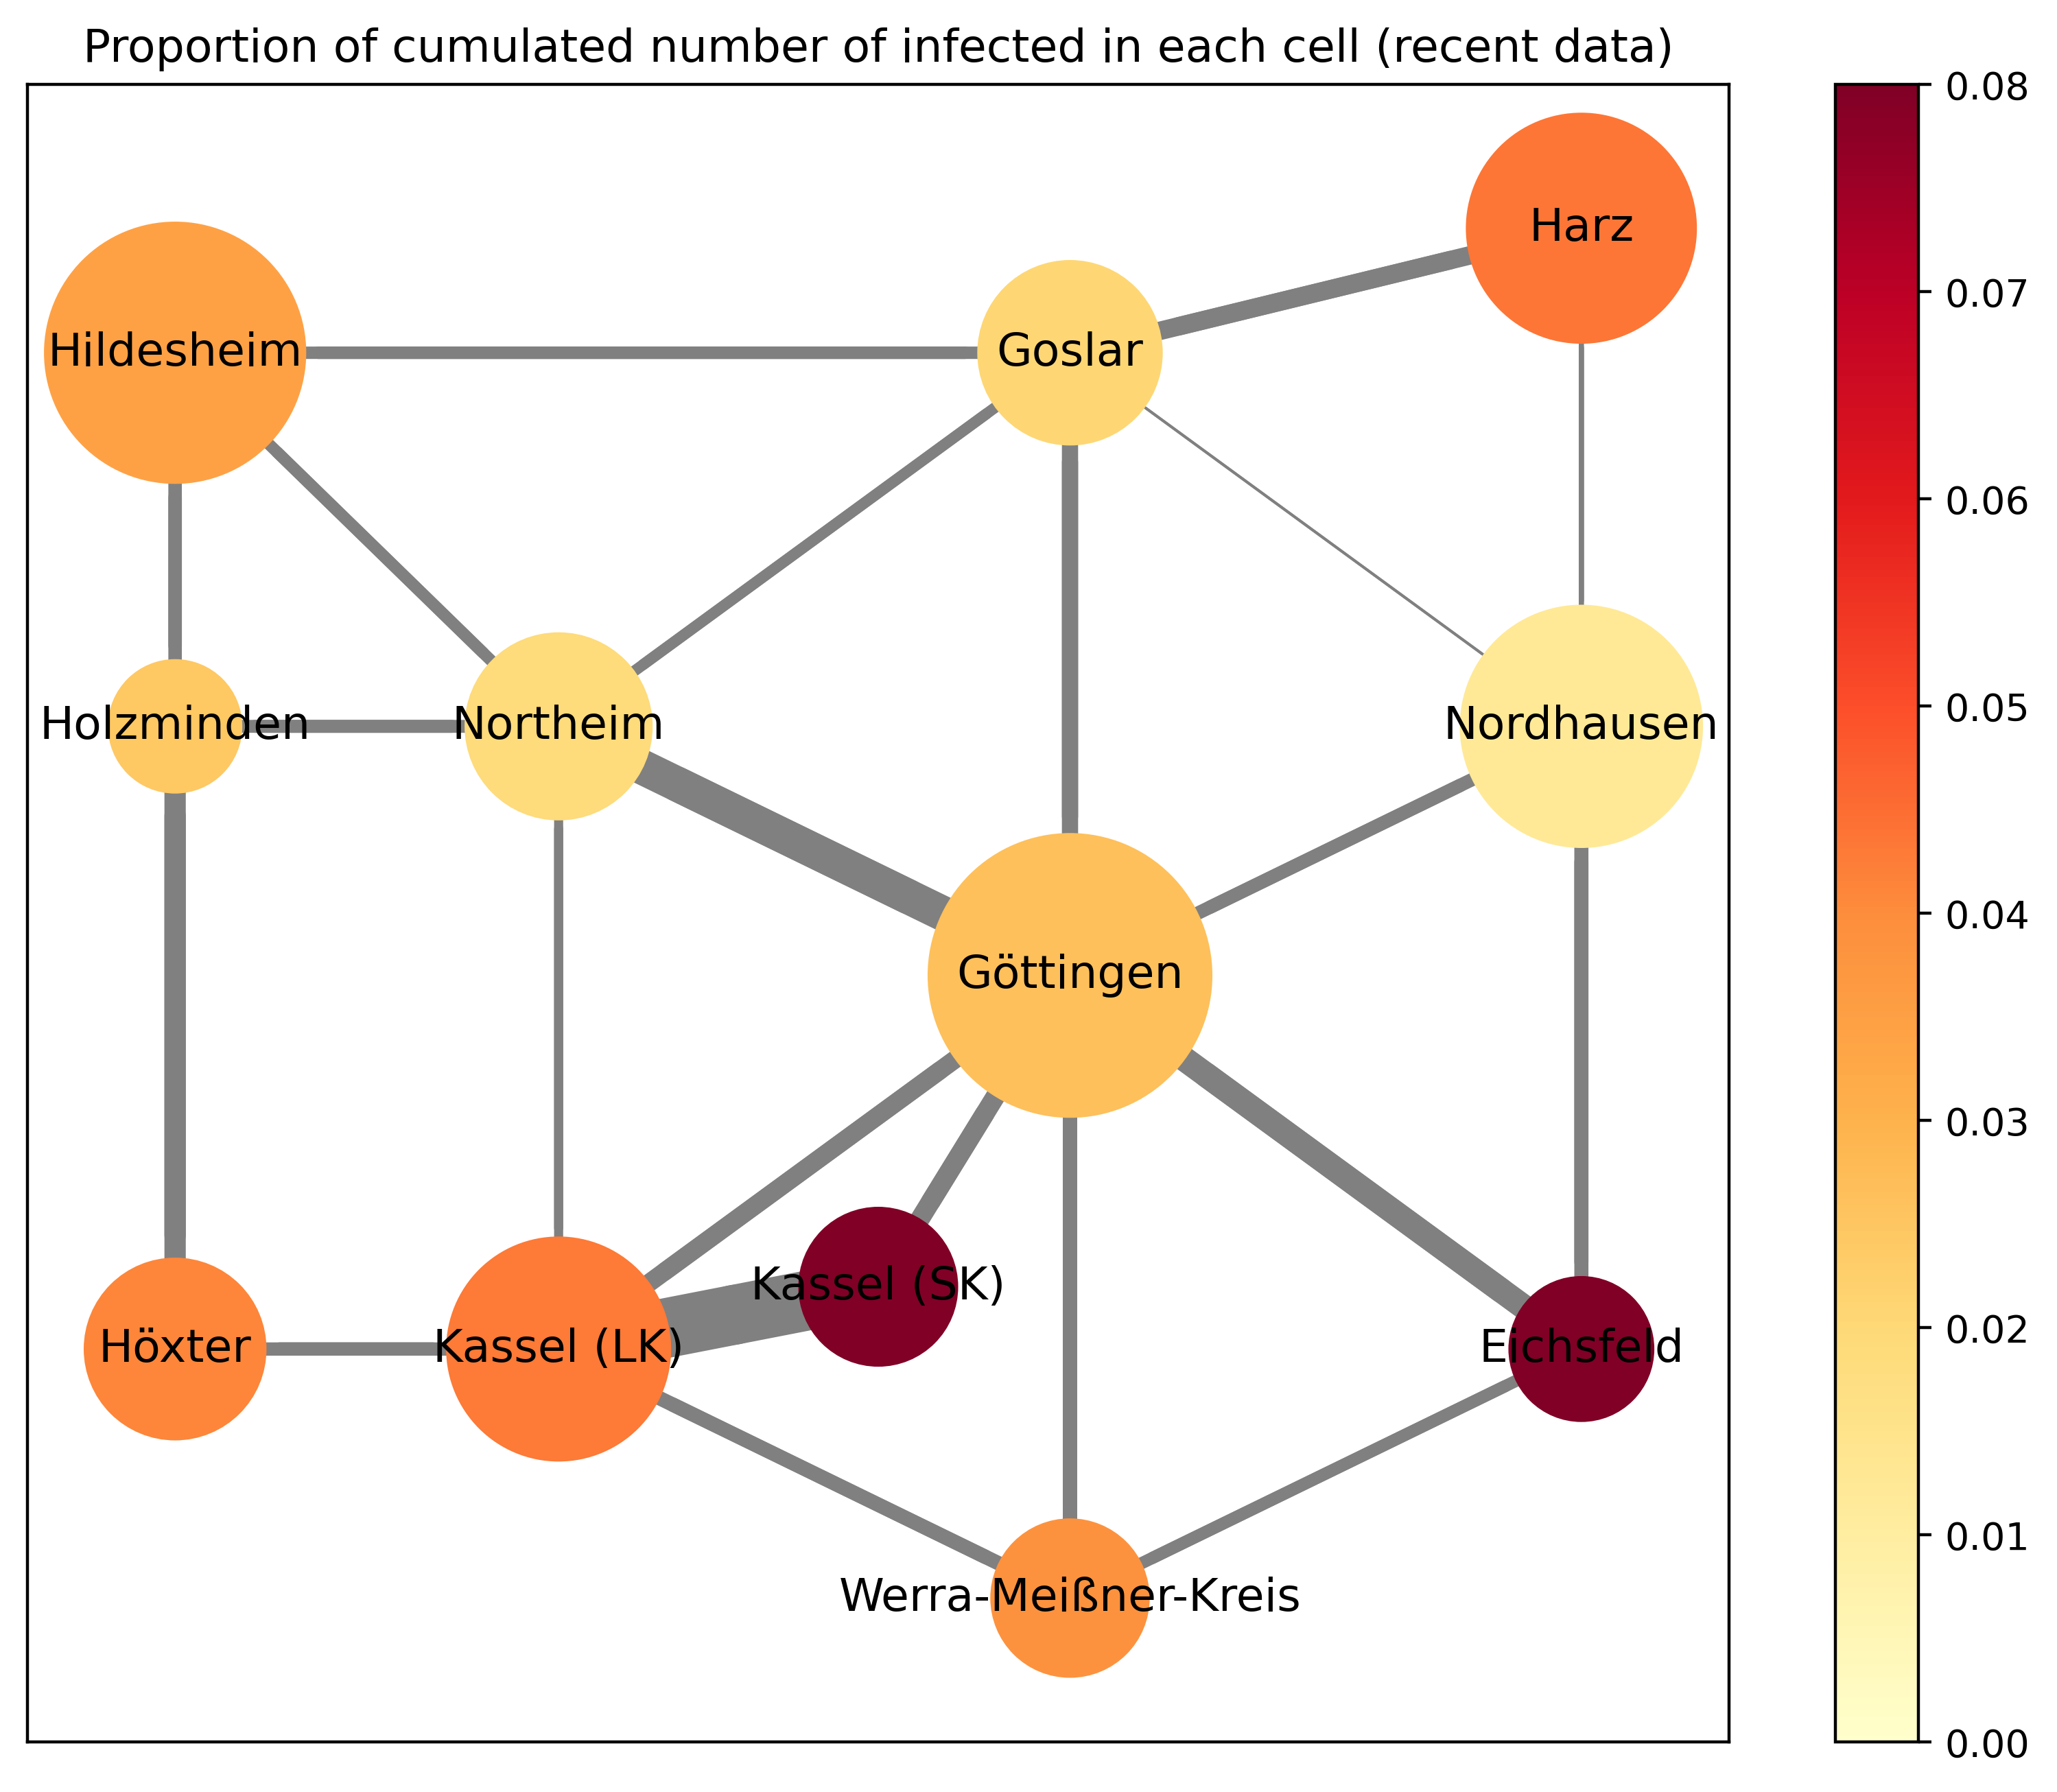

In [186]:
plt.figure(figsize=(10,8), dpi=400)
plt.title('Proportion of cumulated number of infected in each cell (recent data)')
plot_cstate(99)
plt.colorbar(ccm)
plt.show()

Finally, we can once again assemble an animation: (result is not very interesting)

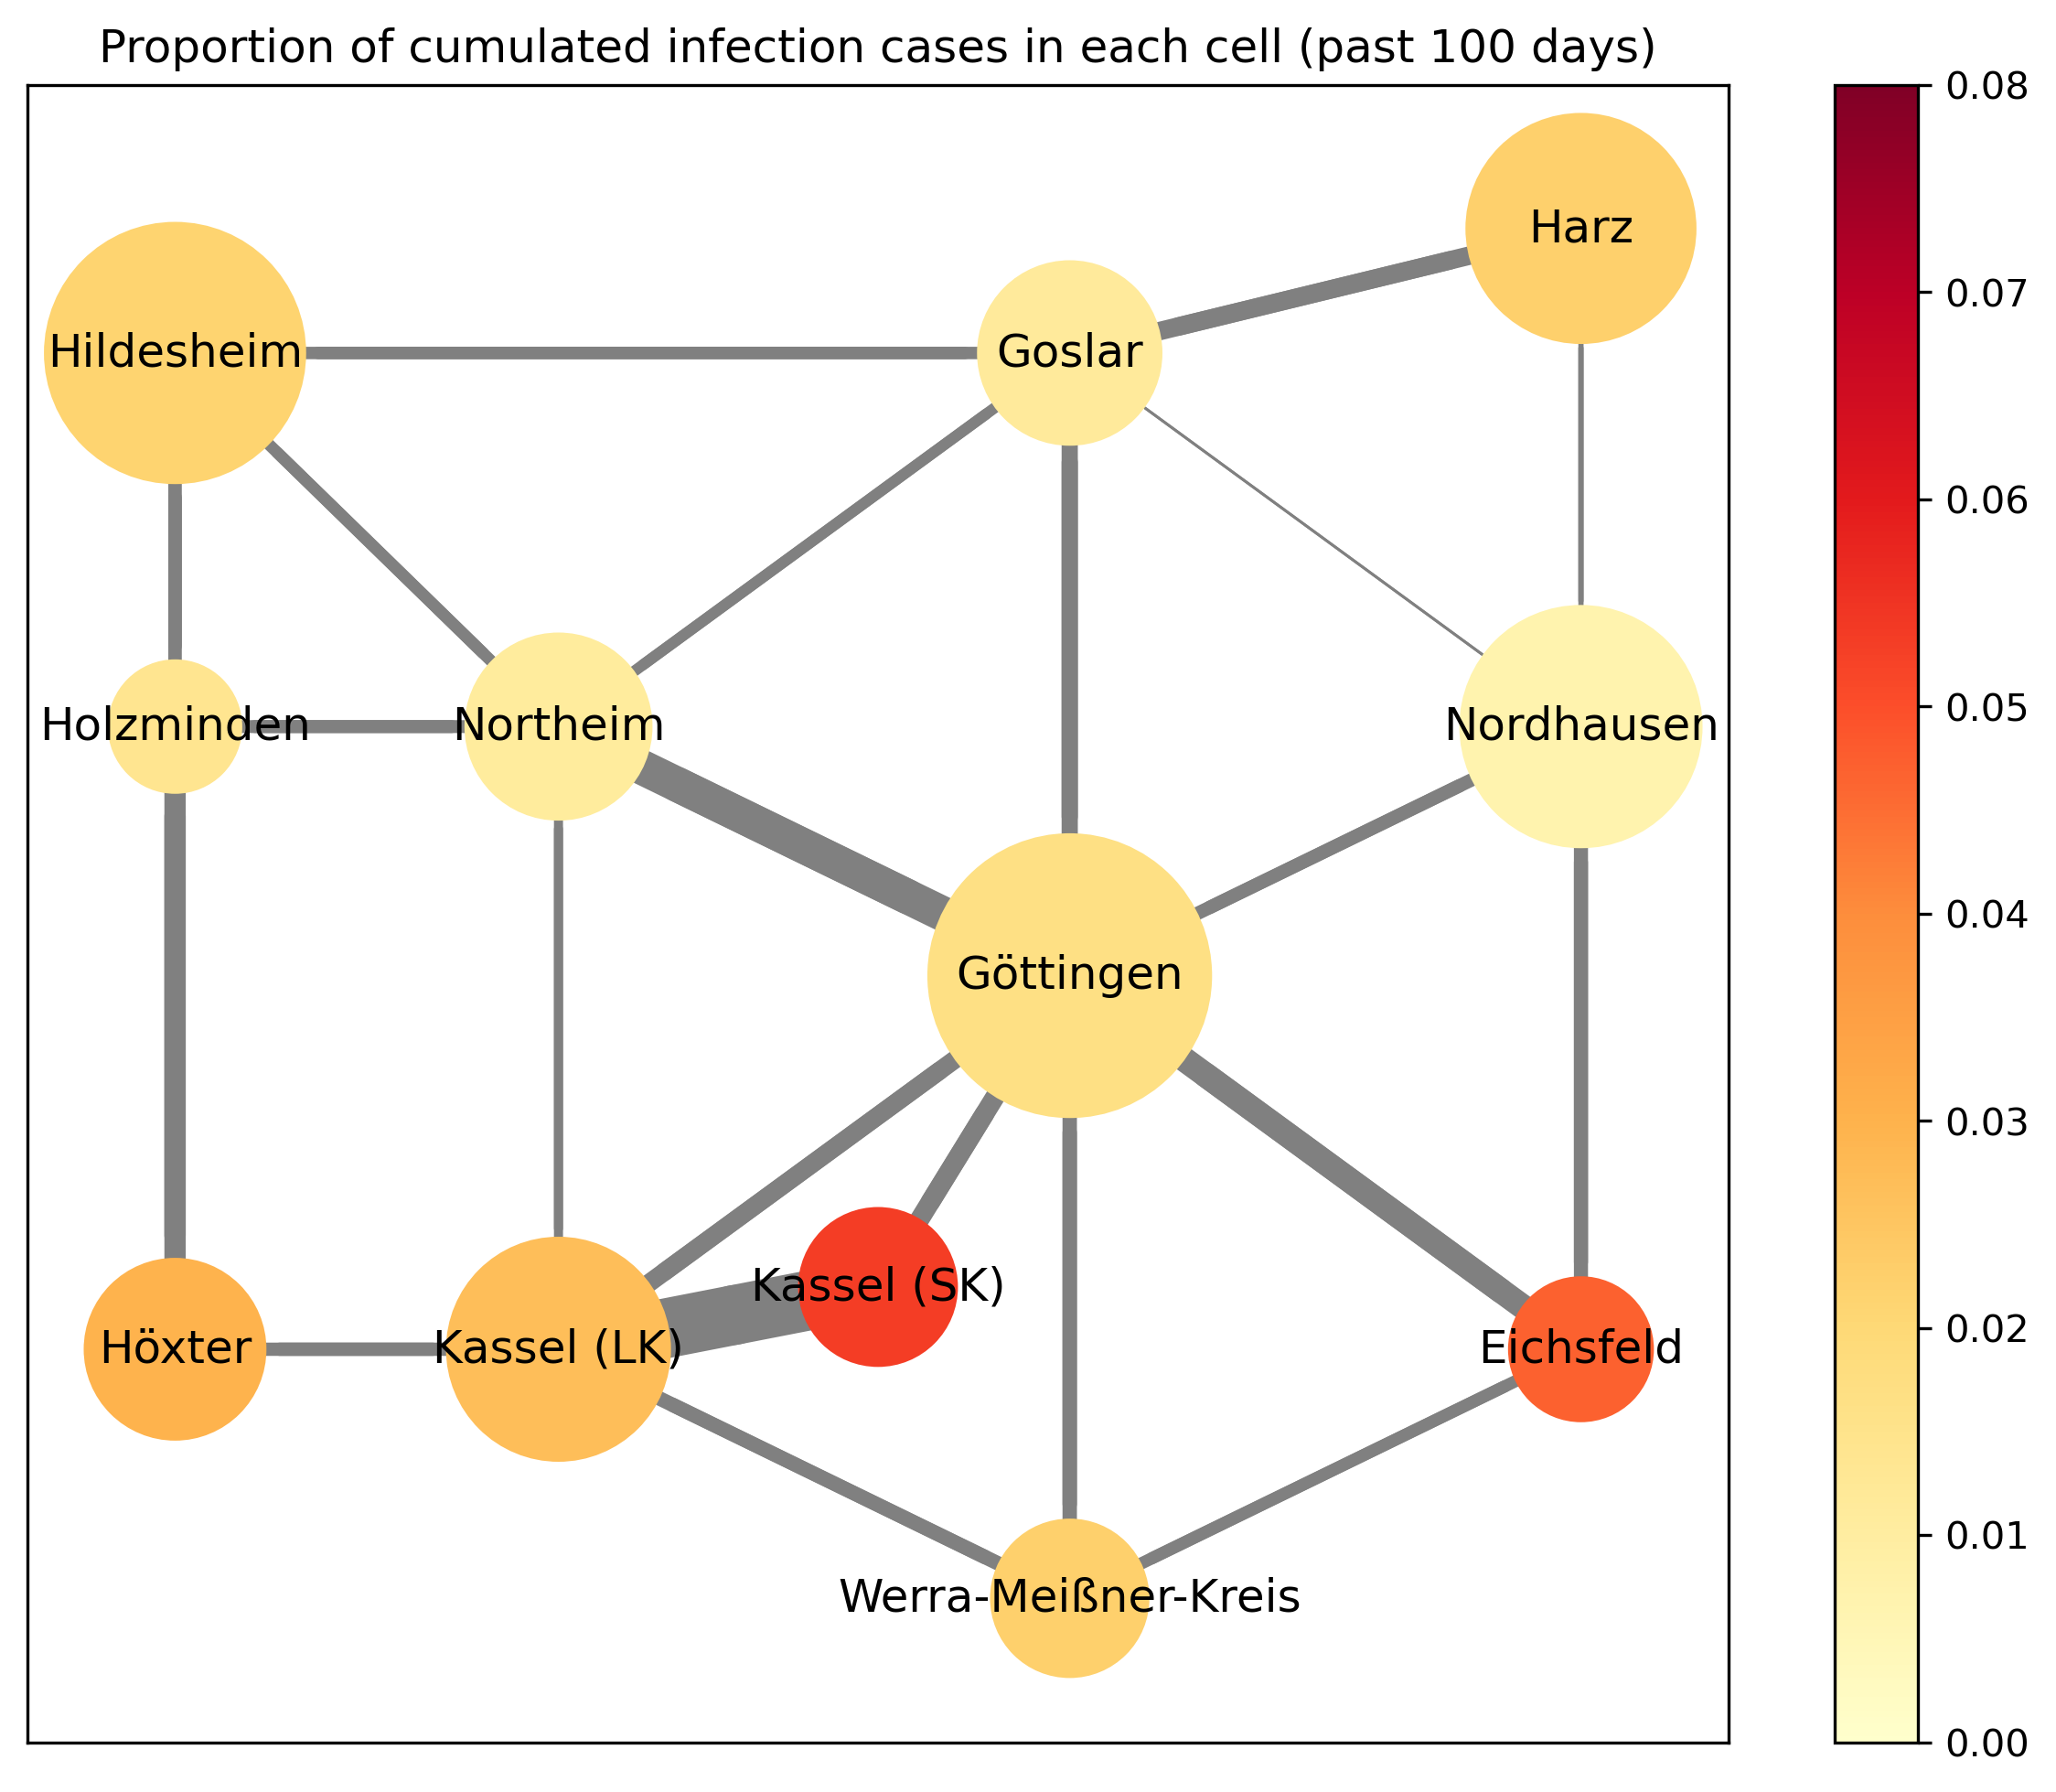

In [187]:
frame_setting=100
interval_setting=math.floor(10000/frame_setting)

plt.figure(figsize=(10,8),dpi=300)
plt.title('Proportion of cumulated infection cases in each cell (past 100 days)')
plt.colorbar(ccm)
ani1 = animation.FuncAnimation(plt.gcf(), plot_cstate,frames=frame_setting, interval=interval_setting, blit=False,repeat_delay=1000)
#HTML(ani1.to_html5_video())

We can also animate 7-day-incidences: (result is very interesting)

In [188]:
sdm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin = 0, vmax=250))
sdm._A = []  
    
def plot_sdstate(animation_time):
    sdmap=[]
    for node in G1:
        sdmap.append(region_cases[node][2][2*animation_time])
    q=nx.draw_networkx(G1,pos,node_size=region_popsize/60, labels=labels,with_labels=True, edge_color='grey',font_color='black', width=weights,node_color=sdmap ,cmap=plt.cm.YlOrRd,vmin=0, vmax=250, arrowsize=1e-10)
    return q

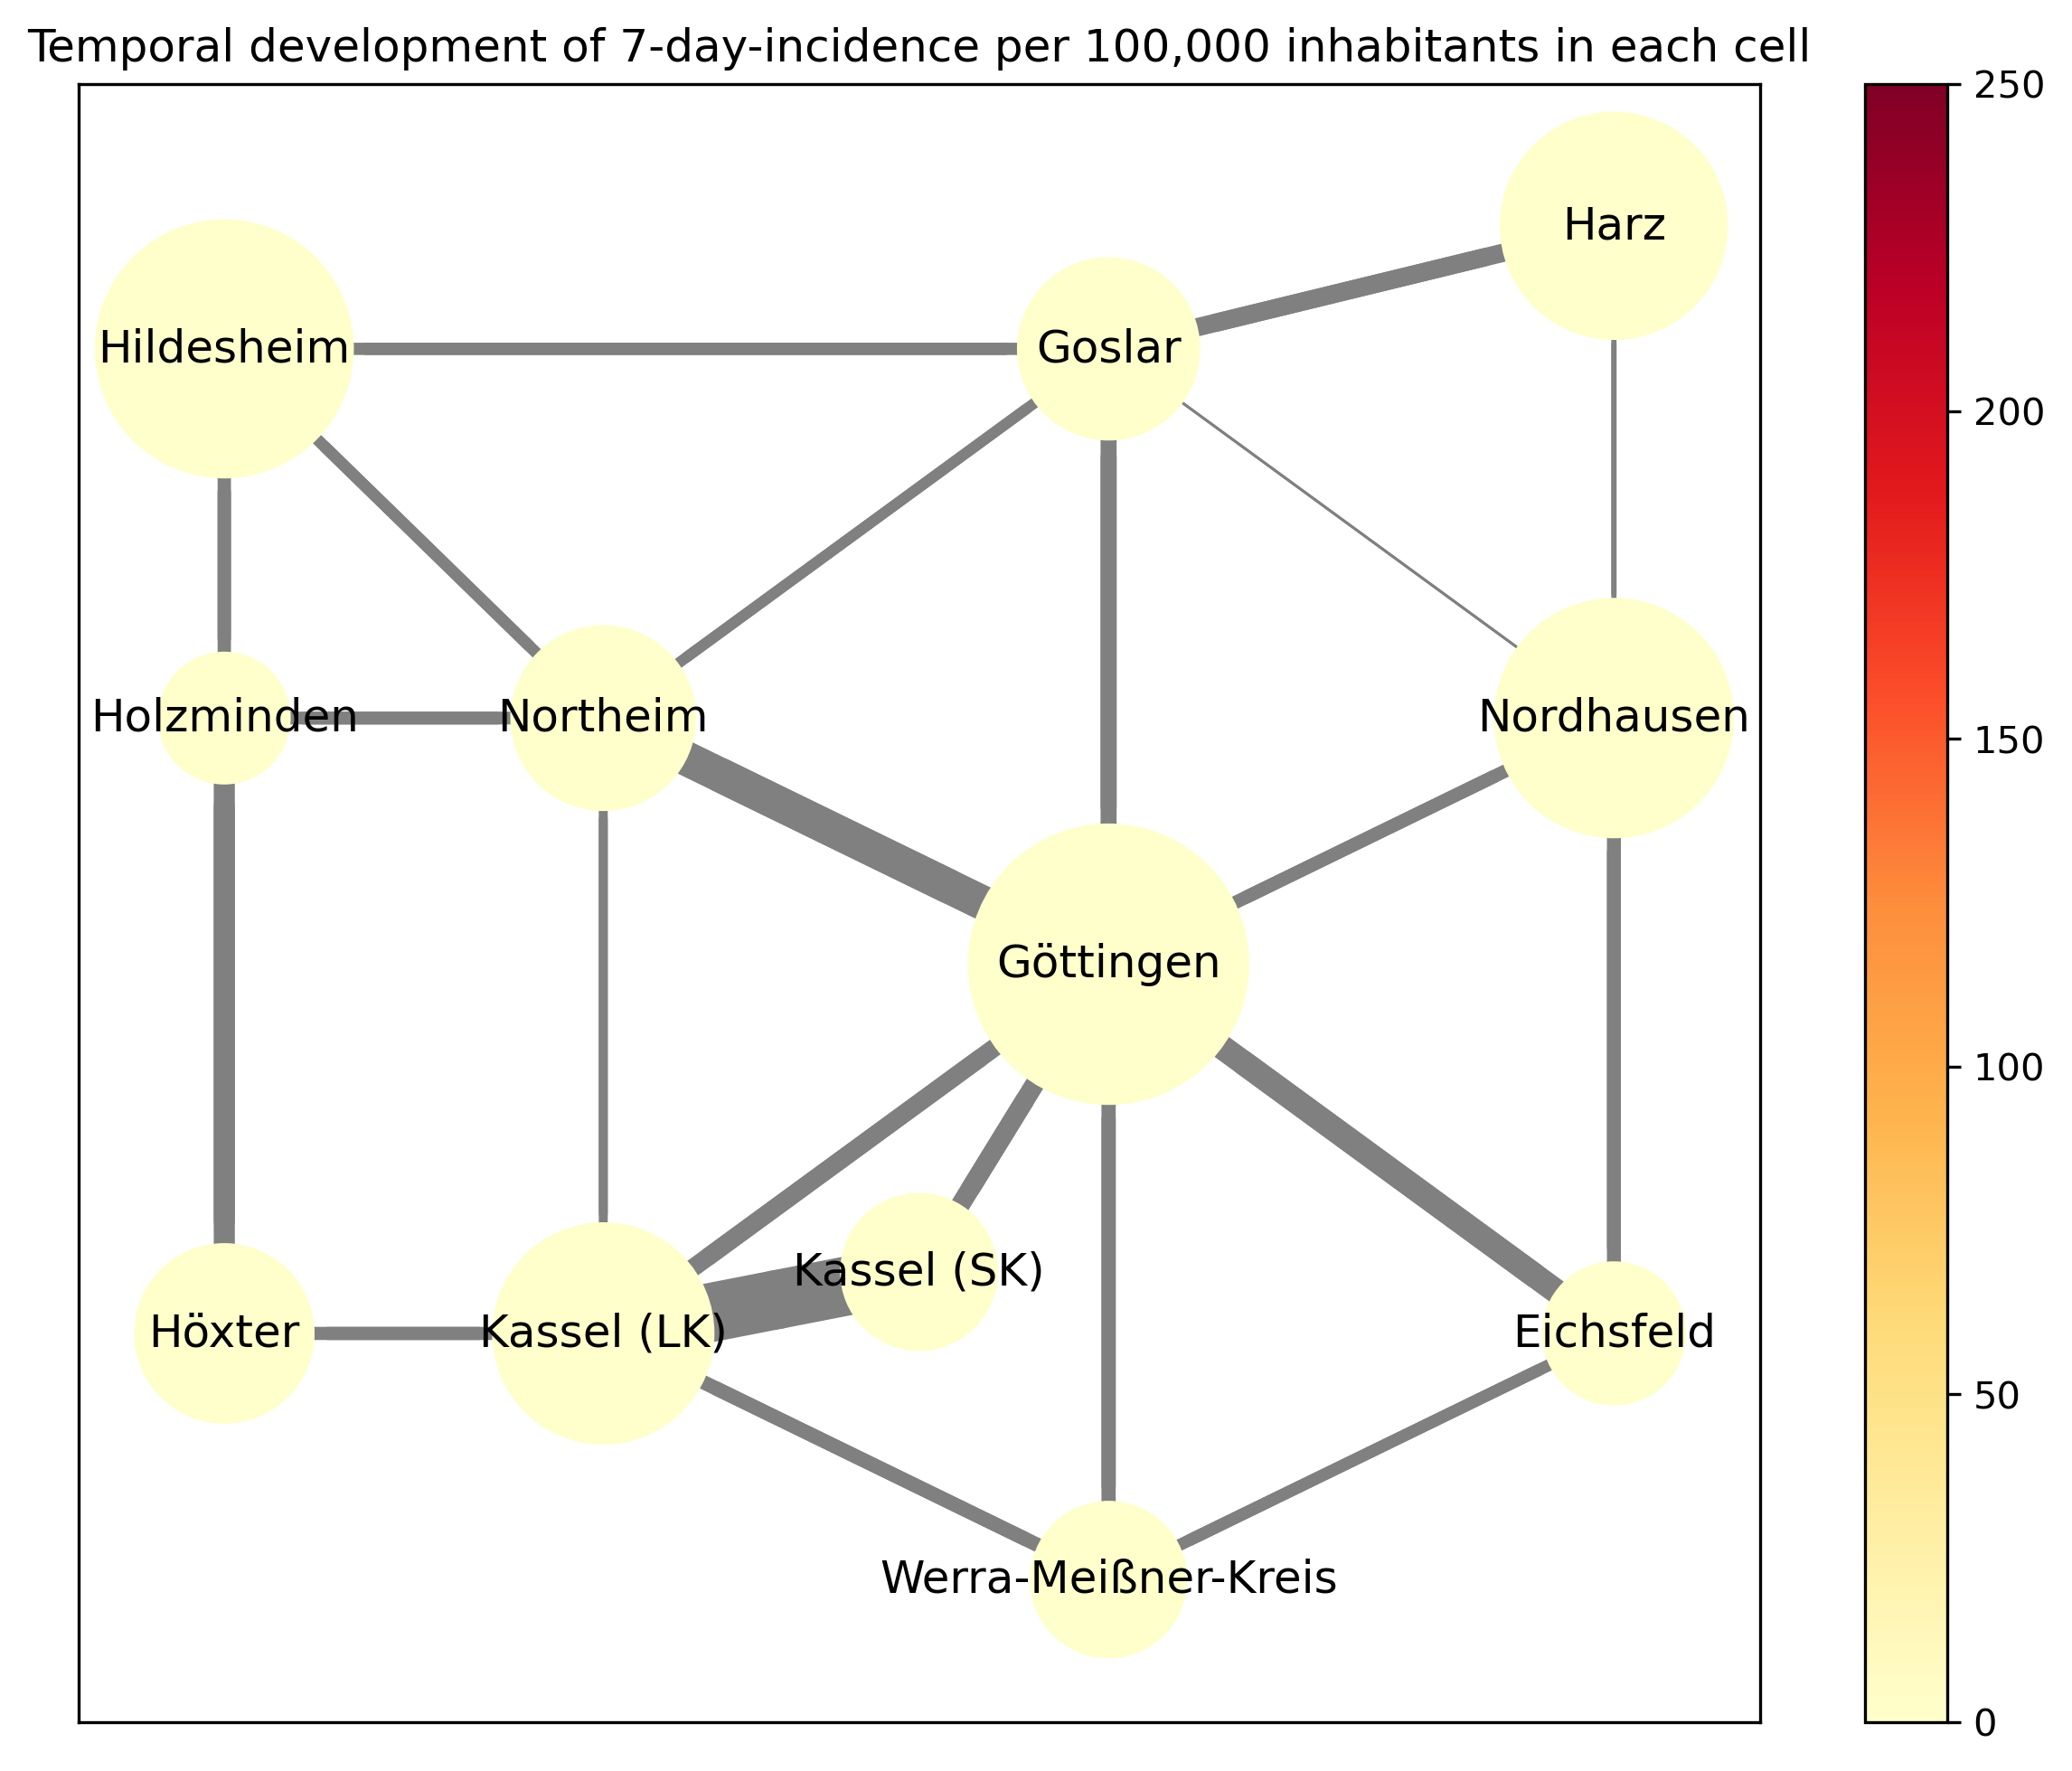

In [189]:
frame_setting=math.floor(time/2)
interval_setting=math.floor(20000/frame_setting)

plt.figure(figsize=(10,8),dpi=300)
plt.title('Temporal development of 7-day-incidence per 100,000 inhabitants in each cell')
plt.colorbar(sdm)
ani1 = animation.FuncAnimation(plt.gcf(), plot_sdstate,frames=frame_setting, interval=interval_setting, blit=False,repeat_delay=1000)
#HTML(ani1.to_html5_video())

## Outlook

- include time display
- improve graph structure